# Imports

In [2]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import sys
sys.path.append('/home/hice1/mbibars3/scratch/vlm-debiasing/VLM-Debiasing-Project/scripts')

In [4]:
%autoreload 2
import pandas as pd
import numpy as np
import os
import model as m
import torch
import torch.nn as nn
import torch.optim as optim
import loaders
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [5]:
import random

def mixup_data(x1, x2, y1, y2, alpha=1.0):
    """
    Perform MixUp between two samples.
    
    Args:
        x1: The first sample (input tensor).
        x2: The second sample (input tensor).
        y1: The first label.
        y2: The second label.
        alpha: The mixing parameter (lambda), which controls the weight of each sample.

    Returns:
        mixed_x: The mixed input tensor.
        mixed_y: The mixed label tensor.
        lambda_value: The value of lambda (how much of each sample is mixed).
    """
    # Generate the mixing factor lambda from a Beta distribution
    lambda_value = torch.distributions.Beta(alpha, alpha).sample().item()

    # Perform MixUp for inputs
    mixed_x = lambda_value * x1 + (1 - lambda_value) * x2
    
    # Perform MixUp for labels
    mixed_y = lambda_value * y1 + (1 - lambda_value) * y2
    
    return mixed_x, mixed_y, lambda_value


# Text-Audio-Visual

- text: Roberta
- audio: AST
- visual: densenet features

# Data

In [6]:
features_csv = pd.read_csv("/home/hice1/mbibars3/scratch/vlm-debiasing/data/e-daic/audio_text_visual_paths.csv")
features_csv.head()

,split,label,label.1,gender,audio,text,visual
0,train,22.0,0,female,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...
1,test,23.0,0,male,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...
2,train,19.0,0,male,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...
3,train,67.0,1,female,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...
4,dev,39.0,0,male,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...


In [7]:
features_csv["label"].mean()

36.443223443223445

In [8]:
# Filter rows that belong to the "train" split
features_csv = pd.read_csv("/home/hice1/mbibars3/scratch/vlm-debiasing/data/e-daic/norm_avt.csv")

In [9]:
# Shuffle the DataFrame
features_csv = features_csv.sample(frac=1, random_state=42).reset_index(drop=True)

# Unbalanced

In [39]:
train_loader = loaders.MultiModalityDataset(features_csv[features_csv["split"]=="train"], 
                                            modalities = {"audio", "text"}, label = "label.1")
train_dataloader = DataLoader(train_loader, batch_size=64, collate_fn=loaders.collate_fn)

for batch in train_dataloader:
    modalities, labels = batch
    print(f"Modality 1 shape: {modalities[0].shape}")  # Expected shape: (batch_size, feature, 1)
    print(f"Modality 2 shape: {modalities[1].shape}")
    #print(f"Modality 3 shape: {modalities[2].shape}")
    print(f"Labels shape: {labels}")
    break

Modality 1 shape: torch.Size([64, 768, 1])
Modality 2 shape: torch.Size([64, 768, 1])
Labels shape: tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1.,
        1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 1., 0., 1., 0., 0., 0., 0.])


In [40]:
dev_loader = loaders.MultiModalityDataset(features_csv[features_csv["split"]=="dev"], 
                                            modalities = {"audio", "text"}, label = "label.1")
dev_dataloader = DataLoader(train_loader, batch_size=16, collate_fn=loaders.collate_fn)

In [41]:
# Define input dimensions for each modality
input_dims = [768, 768]  # These are the feature dimensions for each modality

# Initialize MultiModalPerceiver model
model = m.MultiModalPerceiver(
    input_dims=input_dims,
    input_channels=1,
    input_axis=1,
    projection_dim=256,
    num_latents=16,
    latent_dim=128,
    depth=8,
    cross_heads=8,
    latent_heads=8,
    cross_dim_head=32,
    latent_dim_head=32,
    attn_dropout=0.5,
    ff_dropout=0.5,
    output_dim=1,
    weight_tie_layers=True,
    fourier_encode_data=False,
    max_freq=10,
    num_freq_bands=4
)

In [56]:
simple_model = m.SimpleMultiModalityModel(input_dims, hidden_size=16, output_size=1)

# Print model summary
print(simple_model)

SimpleMultiModalityModel(
  (modality_fc): ModuleList(
    (0-1): 2 x Sequential(
      (0): Linear(in_features=768, out_features=16, bias=True)
      (1): ReLU()
    )
  )
  (combined_fc): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=1, bias=True)
  )
)


In [57]:
sum(p.numel() for p in simple_model.parameters() if p.requires_grad)

25153

In [58]:
labels_torch = torch.from_numpy(features_csv[features_csv["split"]=="train"]["label.1"].values)

In [59]:
# Calculate class weights
class_counts = torch.bincount(labels_torch)  # Get counts for each class
class_weights = len(labels_torch) / (2.0 * class_counts)

# Apply weights to loss function
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])  # Weight for positive class


In [60]:
class_weights

tensor([0.7149, 1.6633])

In [61]:
learning_rate = 0.2
num_epochs = 10
# Define loss function and optimizer
#criterion = nn.MSELoss()  # Mean Squared Error for regression
# loss function for binary classification
#criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(simple_model.parameters(), lr=learning_rate)

In [62]:
from sklearn.metrics import f1_score
# Define variables to track losses
train_losses = []
val_losses = []
best_val_loss = float('inf')  # Initialize best validation loss

# Training loop
for epoch in range(num_epochs):
    running_train_loss = 0.0
    all_train_labels = []
    all_train_preds = []
    all_dev_labels = []
    all_dev_preds = []

    for batch in train_dataloader:
        
        # Unpack the batch
        modalities, labels = batch
        modality_1, modality_2 = modalities  # Each has shape (batch_size, feature, 1)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        inputs = [modality_1, modality_2]
        output = simple_model(inputs)

        #print(output, labels)
        # Reshape labels to match the output shape if necessary
        labels = labels.view(output.shape)  # Ensures labels has shape (batch_size, 1)

        # Compute loss
        loss = criterion(output, labels)
        #RMSE_loss = torch.sqrt(loss)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Accumulate loss
        running_train_loss += loss.item()
        # Convert logits to predictions
        preds = torch.sigmoid(output) > 0.5
        all_train_labels.extend(labels.cpu().numpy().flatten())
        all_train_preds.extend(preds.cpu().numpy().flatten())

    # Average training loss for the epoch
    train_loss = running_train_loss / len(train_dataloader)
    train_losses.append(train_loss)

    # Validation Phase
    model.eval()  # Set model to evaluation mode
    running_val_loss = 0.0

    with torch.no_grad():  # Disable gradient computation
        for batch in dev_dataloader:  # Use validation DataLoader
            modalities, labels = batch
            modality_1, modality_2 = modalities

            # Forward pass
            inputs = [modality_1, modality_2]
            output = simple_model(inputs)

            # Reshape labels to match the output shape if necessary
            labels = labels.view(output.shape)

            # Compute loss
            loss = criterion(output, labels)
            #RMSE_loss = torch.sqrt(loss)

            running_val_loss += loss.item()
            preds = torch.sigmoid(output) > 0.5
            all_dev_labels.extend(labels.cpu().numpy().flatten())
            all_dev_preds.extend(preds.cpu().numpy().flatten())

    # Average validation loss for the epoch
    val_loss = running_val_loss / len(dev_dataloader)
    val_losses.append(val_loss)

    # Check if this is the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_aud_text_model.pth")  # Save best model

    # Compute F1-score for training
    train_f1 = f1_score(all_train_labels, all_train_preds, average='weighted')
    dev_f1 = f1_score(all_dev_labels, all_dev_preds, average='weighted')

    # Print epoch summary
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train F1: {train_f1:.4f}, Val F1: {dev_f1:.4f}")


Epoch [1/10], Train Loss: 9.8140, Val Loss: 0.8194, Train F1: 0.4517, Val F1: 0.5757
Epoch [2/10], Train Loss: 0.8314, Val Loss: 0.8061, Train F1: 0.5757, Val F1: 0.5757
Epoch [3/10], Train Loss: 0.8248, Val Loss: 0.7967, Train F1: 0.5757, Val F1: 0.5757
Epoch [4/10], Train Loss: 0.8222, Val Loss: 0.7934, Train F1: 0.5757, Val F1: 0.5757
Epoch [5/10], Train Loss: 0.8226, Val Loss: 0.7929, Train F1: 0.5757, Val F1: 0.5757
Epoch [6/10], Train Loss: 0.8218, Val Loss: 0.7936, Train F1: 0.5757, Val F1: 0.5757
Epoch [7/10], Train Loss: 0.8199, Val Loss: 0.7964, Train F1: 0.5757, Val F1: 0.5757
Epoch [8/10], Train Loss: 0.8200, Val Loss: 0.7995, Train F1: 0.5757, Val F1: 0.5757
Epoch [9/10], Train Loss: 0.8215, Val Loss: 0.7988, Train F1: 0.5757, Val F1: 0.5757
Epoch [10/10], Train Loss: 0.8219, Val Loss: 0.7959, Train F1: 0.5757, Val F1: 0.5757


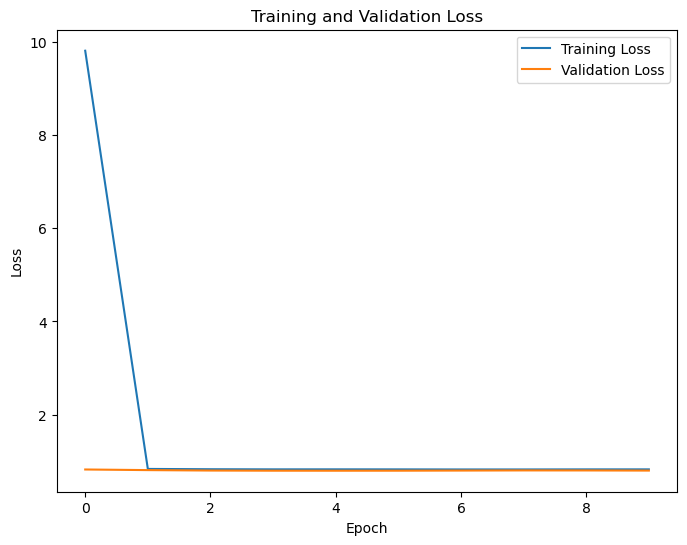

In [63]:
# Plot training and validation losses
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.savefig("loss_plot.png")  # Save the plot
plt.show()

In [65]:
# Model prediction
simple_model.eval()  # Set model to evaluation mode

predictions = []
with torch.no_grad():  # Disable gradient computation
    for batch in dev_dataloader:
        modalities, _ = batch  # Ignore labels if unavailable
        modality_1, modality_2 = modalities
        
        # Forward pass
        inputs = [modality_1, modality_2]
        output = simple_model(inputs)  # Model's prediction
        predictions = torch.sigmoid(output)  # Apply sigmoid activation
        predicted_classes = (predictions > 0.5).int()  # Convert probabilities to binary predictions
        #print(f"Predicted Probabilities:\n{predictions}")
        print(f"Predicted Classes:\n{predicted_classes}")
        # Collect predictions
        #predictions.append(output)

# Combine predictions into a single tensor
#predictions = torch.cat(predicted_classes, dim=0)
#y_pred = np.array(predictions)
#print(f"Predictions:\n{predictions}")

Predicted Classes:
tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], dtype=torch.int32)
Predicted Classes:
tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], dtype=torch.int32)
Predicted Classes:
tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], dtype=torch.int32)
Predicted Classes:
tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], dtype=torch.int32)
Predicted Cl

In [30]:
y_test = np.array(features_csv[features_csv["split"]=="dev"]["PTSD_severity"].values)

In [42]:
features_csv['col_encoded'] = features_csv['gender'].map({'female': 0, 'male': 1, None:1})

In [43]:
np.unique(features_csv['col_encoded'])

array([ 0.,  1., nan])

In [44]:
from fairlearn.metrics import demographic_parity_difference

# Assuming `gender` corresponds to the original metadata
# Split the dataset into training and testing sets for `gender`
gender_train, gender_test = features_csv[features_csv["split"]=="train"]["col_encoded"], features_csv[features_csv["split"]=="dev"]["col_encoded"]

# Ensure that `gender_test`, `y_test`, and `y_pred` are aligned
print(f"Shape of gender_test: {gender_test.shape}")
print(f"Shape of y_test: {y_test.shape}")
print(f"Shape of y_pred: {y_pred.shape}")



Shape of gender_test: (56,)
Shape of y_test: (56,)
Shape of y_pred: (56, 1)


In [47]:
# Calculate Demographic Parity Difference
demographic_parity = demographic_parity_difference(
    y_true=y_test,
    y_pred=y_pred[:,0],
    sensitive_features=gender_test
)

print(f"Demographic Parity Difference: {demographic_parity}")

Demographic Parity Difference: 0.0


In [33]:
from fairlearn.metrics import MetricFrame, selection_rate
metric_frame = MetricFrame(metrics=selection_rate, 
                           y_true=y_test, 
                           y_pred=y_pred[:,0], 
                           sensitive_features=gender_test)

# Get selection rates for each group
selection_rates = metric_frame.by_group
print("Selection Rates by Group:")
print(selection_rates)


Selection Rates by Group:
gender
female     0.0
male       0.0
unknown    0.0
Name: selection_rate, dtype: float64


In [34]:
group_a_rate = selection_rates[1]
group_b_rate = selection_rates[0]

if group_b_rate > 0:  # Avoid division by zero
    demographic_parity_ratio = group_a_rate / group_b_rate
    print(f"Demographic Parity Ratio: {demographic_parity_ratio}")

/scratch/954025/ipykernel_2837344/1510568790.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  group_a_rate = selection_rates[1]
/scratch/954025/ipykernel_2837344/1510568790.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  group_b_rate = selection_rates[0]


# Unbalanced mixup

In [8]:
train_loader = loaders.MultiModalityDataset(features_csv[features_csv["split"]=="train"], 
                                            modalities = {"audio", "text"}, label = "label")
train_dataloader = DataLoader(train_loader, batch_size=10, collate_fn=loaders.collate_fn)

for batch in train_dataloader:
    modalities, labels = batch
    print(f"Modality 1 shape: {modalities[0].shape}")  # Expected shape: (batch_size, feature, 1)
    print(f"Modality 2 shape: {modalities[1].shape}")
    #print(f"Modality 3 shape: {modalities[2].shape}")
    print(f"Labels shape: {labels}")
    break

Modality 1 shape: torch.Size([10, 768, 1])
Modality 2 shape: torch.Size([10, 768, 1])
Labels shape: tensor([29., 32., 48., 72., 58., 36., 48., 46., 27., 24.])


In [9]:
dev_loader = loaders.MultiModalityDataset(features_csv[features_csv["split"]=="dev"], 
                                            modalities = {"audio", "text"}, label = "label")
dev_dataloader = DataLoader(train_loader, batch_size=10, collate_fn=loaders.collate_fn)

In [10]:
# Define input dimensions for each modality
input_dims = [768, 768]  # These are the feature dimensions for each modality

# Initialize MultiModalPerceiver model
model = m.MultiModalPerceiver(
    input_dims=input_dims,
    input_channels=1,
    input_axis=1,
    projection_dim=256,
    num_latents=16,
    latent_dim=128,
    depth=8,
    cross_heads=8,
    latent_heads=8,
    cross_dim_head=32,
    latent_dim_head=32,
    attn_dropout=0.5,
    ff_dropout=0.5,
    output_dim=1,
    weight_tie_layers=True,
    fourier_encode_data=False,
    max_freq=10,
    num_freq_bands=4
)

In [11]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

1585541

In [12]:
"""
labels_torch = torch.from_numpy(features_csv[features_csv["split"]=="train"]["label.1"].values)
# Calculate class weights
class_counts = torch.bincount(labels_torch)  # Get counts for each class
class_weights = len(labels_torch) / (2.0 * class_counts)

# Apply weights to loss function
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])  # Weight for positive class"""

'\nlabels_torch = torch.from_numpy(features_csv[features_csv["split"]=="train"]["label.1"].values)\n# Calculate class weights\nclass_counts = torch.bincount(labels_torch)  # Get counts for each class\nclass_weights = len(labels_torch) / (2.0 * class_counts)\n\n# Apply weights to loss function\ncriterion = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])  # Weight for positive class'

In [13]:
learning_rate = 0.0005
num_epochs = 10
mix_prob = 0.8
alpha = 0.7
# Define loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error for regression
# loss function for binary classification
#criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [14]:
from sklearn.metrics import f1_score
# Define variables to track losses
train_losses = []
val_losses = []
best_val_loss = float('inf')  # Initialize best validation loss

# Training loop
for epoch in range(num_epochs):
    model.train()

    running_train_loss = 0.0
    all_train_labels = []
    all_train_preds = []
    all_dev_labels = []
    all_dev_preds = []

    for batch in train_dataloader:
        
        # Unpack the batch
        modalities, labels = batch
        modality_1, modality_2 = modalities  # Each has shape (batch_size, feature, 1)

        # Zero the parameter gradients for every batch!
        optimizer.zero_grad()

        # MixUp: randomly select a pair of samples and mix them
        if random.random() < mix_prob:  # Apply MixUp with a probability of 50%
            # Select a random index for mixing
            index = torch.randperm(modality_1.shape[0]).to(modality_1.device)
            
            # Perform MixUp for each modality
            modality_1, labels, lambda_value = mixup_data(modality_1, modality_1[index], labels, labels[index], alpha=alpha)
            modality_2, _, _ = mixup_data(modality_2, modality_2[index], labels, labels[index], alpha=alpha)
            #modality_3, _, _ = mixup_data(modality_3, modality_3[index], labels, labels[index], alpha=alpha)
        

        # Forward pass
        inputs = [modality_1, modality_2]
        output = model(inputs)

        # Reshape labels to match the output shape if necessary
        labels = labels.view(output.shape)  # Ensures labels has shape (batch_size, 1)

        # Compute loss
        loss = criterion(output, labels)
        loss = torch.sqrt(loss)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Accumulate loss
        running_train_loss += loss.item()
        # Convert logits to predictions
        #preds = torch.sigmoid(output) > 0.5
        #all_train_labels.extend(labels.cpu().numpy().flatten())
        #all_train_preds.extend(preds.cpu().numpy().flatten())

    # Average training loss for the epoch
    train_loss = running_train_loss / len(train_dataloader)
    train_losses.append(train_loss)

    # Validation Phase
    model.eval()  # Set model to evaluation mode
    running_val_loss = 0.0

    with torch.no_grad():  # Disable gradient computation
        for batch in dev_dataloader:  # Use validation DataLoader
            modalities, labels = batch
            modality_1, modality_2 = modalities

            # Forward pass
            inputs = [modality_1, modality_2]
            output = model(inputs)

            # Reshape labels to match the output shape if necessary
            labels = labels.view(output.shape)

            # Compute loss
            loss = criterion(output, labels)
            loss = torch.sqrt(loss)

            running_val_loss += loss.item()
            #preds = torch.sigmoid(output) > 0.5
            #all_dev_labels.extend(labels.cpu().numpy().flatten())
            #all_dev_preds.extend(preds.cpu().numpy().flatten())

    # Average validation loss for the epoch
    val_loss = running_val_loss / len(dev_dataloader)
    val_losses.append(val_loss)

    # Check if this is the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_aud_text_model.pth")  # Save best model

    # Compute F1-score for training
    #train_f1 = f1_score(all_train_labels, all_train_preds, average='weighted')
    #dev_f1 = f1_score(all_dev_labels, all_dev_preds, average='weighted')

    # Print epoch summary
    #print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train F1: {train_f1:.4f}, Val F1: {dev_f1:.4f}")
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


Epoch [1/10], Train Loss: 31.9484, Val Loss: 31.5414
Epoch [2/10], Train Loss: 29.9905, Val Loss: 30.5198
Epoch [3/10], Train Loss: 29.1958, Val Loss: 29.4735
Epoch [4/10], Train Loss: 27.6234, Val Loss: 28.3719
Epoch [5/10], Train Loss: 26.5436, Val Loss: 27.2164
Epoch [6/10], Train Loss: 25.6528, Val Loss: 26.0482
Epoch [7/10], Train Loss: 24.6642, Val Loss: 24.8661
Epoch [8/10], Train Loss: 23.1667, Val Loss: 23.6870
Epoch [9/10], Train Loss: 22.1232, Val Loss: 22.5333
Epoch [10/10], Train Loss: 20.7716, Val Loss: 21.4493


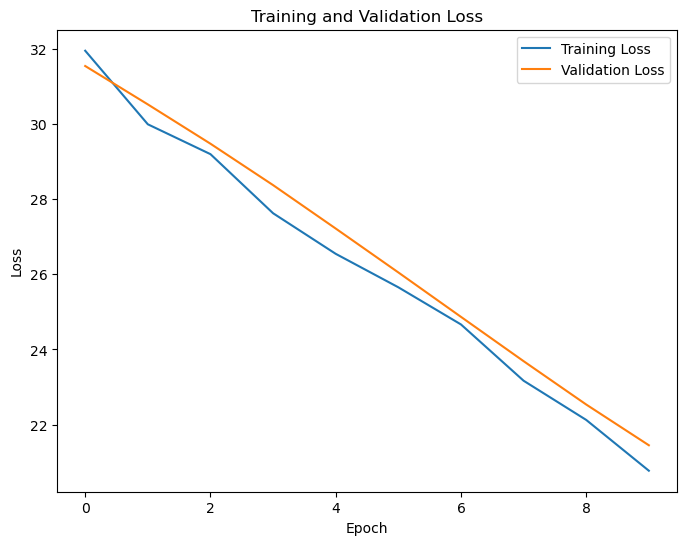

In [15]:
# Plot training and validation losses
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.savefig("loss_plot.png")  # Save the plot
plt.show()

In [17]:
# Model prediction
model.eval()  # Set model to evaluation mode

predictions = []
with torch.no_grad():  # Disable gradient computation
    for batch in dev_dataloader:
        modalities, _ = batch  # Ignore labels if unavailable
        modality_1, modality_2 = modalities
        
        # Forward pass
        inputs = [modality_1, modality_2]
        output = model(inputs)  # Model's prediction
        #predictions = torch.sigmoid(output)  # Apply sigmoid activation
        #predicted_classes = (predictions > 0.5).int()  # Convert probabilities to binary predictions
        #print(f"Predicted Probabilities:\n{predictions}")
        #print(f"Predicted Classes:\n{predicted_classes}")
        # Collect predictions
        predictions.append(output)

# Combine predictions into a single tensor
#predictions = torch.cat(predicted_classes, dim=0)
#y_pred = np.array(predictions)
out = np.concatenate(predictions).ravel()

print(f"Predictions:\n{np.unique(out)}")

Predictions:
[20.82246]


# Unbalanced LARGE MODEL

In [19]:
train_loader = loaders.MultiModalityDataset(features_csv[features_csv["split"]=="train"], 
                                            modalities = {"audio", "text"}, label = "label")
train_dataloader = DataLoader(train_loader, batch_size=10, collate_fn=loaders.collate_fn)

for batch in train_dataloader:
    modalities, labels = batch
    print(f"Modality 1 shape: {modalities[0].shape}")  # Expected shape: (batch_size, feature, 1)
    print(f"Modality 2 shape: {modalities[1].shape}")
    #print(f"Modality 3 shape: {modalities[2].shape}")
    print(f"Labels shape: {labels}")
    break

Modality 1 shape: torch.Size([10, 768, 1])
Modality 2 shape: torch.Size([10, 768, 1])
Labels shape: tensor([29., 32., 48., 72., 58., 36., 48., 46., 27., 24.])


In [20]:
dev_loader = loaders.MultiModalityDataset(features_csv[features_csv["split"]=="dev"], 
                                            modalities = {"audio", "text"}, label = "label")
dev_dataloader = DataLoader(train_loader, batch_size=10, collate_fn=loaders.collate_fn)

In [21]:
# Define input dimensions for each modality
input_dims = [768, 768]  # These are the feature dimensions for each modality

# Initialize MultiModalPerceiver model
model = m.SimpleMultiModalityModel(input_sizes=input_dims, hidden_size=1000, output_size=1)

In [22]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

3540001

In [23]:
"""
labels_torch = torch.from_numpy(features_csv[features_csv["split"]=="train"]["label.1"].values)
# Calculate class weights
class_counts = torch.bincount(labels_torch)  # Get counts for each class
class_weights = len(labels_torch) / (2.0 * class_counts)

# Apply weights to loss function
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])  # Weight for positive class"""

'\nlabels_torch = torch.from_numpy(features_csv[features_csv["split"]=="train"]["label.1"].values)\n# Calculate class weights\nclass_counts = torch.bincount(labels_torch)  # Get counts for each class\nclass_weights = len(labels_torch) / (2.0 * class_counts)\n\n# Apply weights to loss function\ncriterion = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])  # Weight for positive class'

In [25]:
learning_rate = 0.001
num_epochs = 10
mix_prob = 0
alpha = 0.7
# Define loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error for regression
# loss function for binary classification
#criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [29]:
from sklearn.metrics import f1_score
# Define variables to track losses
train_losses = []
val_losses = []
best_val_loss = float('inf')  # Initialize best validation loss

# Training loop
for epoch in range(num_epochs):
    model.train()

    running_train_loss = 0.0
    all_train_labels = []
    all_train_preds = []
    all_dev_labels = []
    all_dev_preds = []

    for batch in train_dataloader:
        
        # Unpack the batch
        modalities, labels = batch
        modality_1, modality_2 = modalities  # Each has shape (batch_size, feature, 1)

        # Zero the parameter gradients for every batch!
        optimizer.zero_grad()

        # MixUp: randomly select a pair of samples and mix them
        if random.random() < mix_prob:  # Apply MixUp with a probability of 50%
            # Select a random index for mixing
            index = torch.randperm(modality_1.shape[0]).to(modality_1.device)
            
            # Perform MixUp for each modality
            modality_1, labels, lambda_value = mixup_data(modality_1, modality_1[index], labels, labels[index], alpha=alpha)
            modality_2, _, _ = mixup_data(modality_2, modality_2[index], labels, labels[index], alpha=alpha)
            #modality_3, _, _ = mixup_data(modality_3, modality_3[index], labels, labels[index], alpha=alpha)
        

        # Forward pass
        inputs = [modality_1, modality_2]
        output = model(inputs)

        # Reshape labels to match the output shape if necessary
        labels = labels.view(output.shape)  # Ensures labels has shape (batch_size, 1)

        # Compute loss
        loss = criterion(output, labels)
        loss = torch.sqrt(loss)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Accumulate loss
        running_train_loss += loss.item()
        # Convert logits to predictions
        #preds = torch.sigmoid(output) > 0.5
        #all_train_labels.extend(labels.cpu().numpy().flatten())
        #all_train_preds.extend(preds.cpu().numpy().flatten())

    # Average training loss for the epoch
    train_loss = running_train_loss / len(train_dataloader)
    train_losses.append(train_loss)

    # Validation Phase
    model.eval()  # Set model to evaluation mode
    running_val_loss = 0.0

    with torch.no_grad():  # Disable gradient computation
        for batch in dev_dataloader:  # Use validation DataLoader
            modalities, labels = batch
            modality_1, modality_2 = modalities

            # Forward pass
            inputs = [modality_1, modality_2]
            output = model(inputs)

            # Reshape labels to match the output shape if necessary
            labels = labels.view(output.shape)

            # Compute loss
            loss = criterion(output, labels)
            loss = torch.sqrt(loss)

            running_val_loss += loss.item()
            #preds = torch.sigmoid(output) > 0.5
            #all_dev_labels.extend(labels.cpu().numpy().flatten())
            #all_dev_preds.extend(preds.cpu().numpy().flatten())

    # Average validation loss for the epoch
    val_loss = running_val_loss / len(dev_dataloader)
    val_losses.append(val_loss)

    # Check if this is the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        print("best val loss ", epoch, ": ", best_val_loss)
        #torch.save(model.state_dict(), "best_aud_text_model.pth")  # Save best model

    # Compute F1-score for training
    #train_f1 = f1_score(all_train_labels, all_train_preds, average='weighted')
    #dev_f1 = f1_score(all_dev_labels, all_dev_preds, average='weighted')

    # Print epoch summary
    #print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train F1: {train_f1:.4f}, Val F1: {dev_f1:.4f}")
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


best val loss  0 :  17.312126608455884
Epoch [1/10], Train Loss: 18.5241, Val Loss: 17.3121
Epoch [2/10], Train Loss: 18.4895, Val Loss: 17.3316
best val loss  2 :  17.199425304637234
Epoch [3/10], Train Loss: 18.4960, Val Loss: 17.1994
best val loss  3 :  17.150218963623047
Epoch [4/10], Train Loss: 18.3904, Val Loss: 17.1502
best val loss  4 :  17.142191830803366
Epoch [5/10], Train Loss: 18.3138, Val Loss: 17.1422
best val loss  5 :  17.113280464621152
Epoch [6/10], Train Loss: 18.2807, Val Loss: 17.1133
Epoch [7/10], Train Loss: 18.2401, Val Loss: 17.1568
best val loss  7 :  17.085153579711914
Epoch [8/10], Train Loss: 18.2569, Val Loss: 17.0852
Epoch [9/10], Train Loss: 18.1951, Val Loss: 17.0913
best val loss  9 :  17.050873700310202
Epoch [10/10], Train Loss: 18.1739, Val Loss: 17.0509


In [30]:
# Model prediction
model.eval()  # Set model to evaluation mode

predictions = []
with torch.no_grad():  # Disable gradient computation
    for batch in train_dataloader:
        modalities, _ = batch  # Ignore labels if unavailable
        modality_1, modality_2 = modalities
        
        # Forward pass
        inputs = [modality_1, modality_2]
        output = model(inputs)  # Model's prediction
        #predicts = torch.sigmoid(output)  # Apply sigmoid activation
        #predicted_classes = (predicts > 0.5).int()  # Convert probabilities to binary predictions
        #print(f"Predicted Probabilities:\n{predictions}")
        #print(f"Predicted Classes:\n{predicted_classes}")
        # Collect predictions
        predictions.append(output)
        #predictions.append(predicted_classes)

# Combine predictions into a single tensor
#predictions = torch.cat(predicted_classes, dim=0)
#y_pred = np.array(predictions)
out = np.concatenate(predictions).ravel()

print(f"Predictions:\n{np.unique(out)}")

Predictions:
[38.59332  38.59364  38.596455 38.597645 38.599033 38.60244  38.603867
 38.61049  38.612144 38.614117 38.62067  38.620853 38.62226  38.622658
 38.62568  38.62812  38.62937  38.629974 38.63143  38.631817 38.634766
 38.637268 38.639225 38.639328 38.639763 38.64183  38.645046 38.64513
 38.645203 38.64625  38.64888  38.649296 38.654987 38.655746 38.658264
 38.65899  38.66166  38.66176  38.66928  38.671658 38.672386 38.672855
 38.689327 38.690765 38.695312 38.69623  38.698708 38.699684 38.703465
 38.706905 38.707874 38.710564 38.710693 38.711    38.713158 38.713577
 38.716248 38.717304 38.718456 38.725304 38.732304 38.73274  38.733463
 38.733963 38.734947 38.73866  38.73868  38.74126  38.742256 38.746117
 38.74669  38.74898  38.759644 38.763393 38.765068 38.774696 38.77488
 38.776333 38.77686  38.77963  38.783485 38.786243 38.789486 38.790684
 38.793213 38.793236 38.794144 38.797512 38.800163 38.80163  38.8026
 38.80539  38.807014 38.808376 38.80933  38.811775 38.82021  38.8239

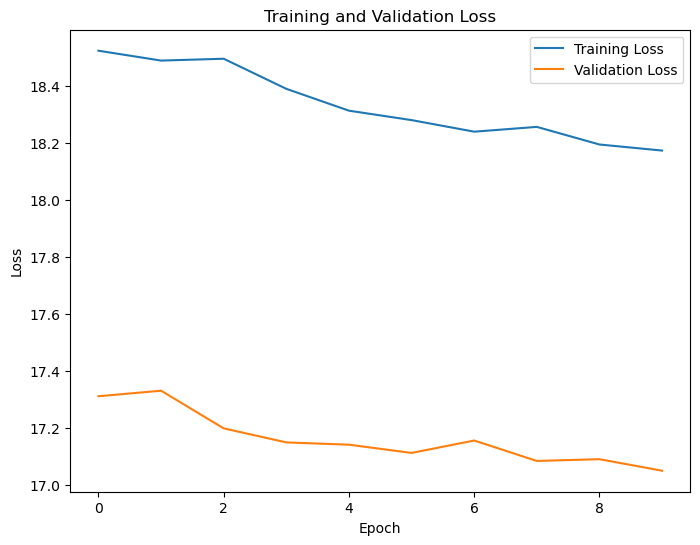

In [31]:
# Plot training and validation losses
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.savefig("loss_plot.png")  # Save the plot
plt.show()

In [42]:
y_pred= out

In [44]:
y_test = np.array(features_csv[features_csv["split"]=="train"]["label"].values)

In [38]:
np.unique(features_csv['gender'])

array(['female', 'male', 'unknown'], dtype=object)

In [45]:
features_csv['col_encoded'] = features_csv['gender'].map({'female': 0, 'male': 1, 'unknown':1})

In [46]:
np.unique(features_csv['col_encoded'])

array([0, 1])

In [47]:
from fairlearn.metrics import demographic_parity_difference

# Assuming `gender` corresponds to the original metadata
# Split the dataset into training and testing sets for `gender`
gender_train, gender_test = features_csv[features_csv["split"]=="train"]["col_encoded"], features_csv[features_csv["split"]=="dev"]["col_encoded"]

# Ensure that `gender_test`, `y_test`, and `y_pred` are aligned
print(f"Shape of gender_test: {gender_train.shape}")
print(f"Shape of y_test: {y_test.shape}")
print(f"Shape of y_pred: {y_pred.shape}")



Shape of gender_test: (163,)
Shape of y_test: (163,)
Shape of y_pred: (163,)


In [50]:
# Calculate Demographic Parity Difference
demographic_parity = demographic_parity_difference(
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=gender_train
)

print(f"Demographic Parity Difference: {demographic_parity}")

Demographic Parity Difference: 0.0


In [51]:
from fairlearn.metrics import MetricFrame, selection_rate
metric_frame = MetricFrame(metrics=selection_rate, 
                           y_true=y_test, 
                           y_pred=y_pred, 
                           sensitive_features=gender_train)

# Get selection rates for each group
selection_rates = metric_frame.by_group
print("Selection Rates by Group:")
print(selection_rates)


Selection Rates by Group:
col_encoded
0    0.0
1    0.0
Name: selection_rate, dtype: float64


In [52]:
group_a_rate = selection_rates[1]
group_b_rate = selection_rates[0]

if group_b_rate > 0:  # Avoid division by zero
    demographic_parity_ratio = group_a_rate / group_b_rate
    print(f"Demographic Parity Ratio: {demographic_parity_ratio}")

# Unbalanced simple MODEL with normalized target distribution

In [10]:
# Apply normalization separately for each split
from sklearn.preprocessing import MinMaxScaler
features_csv = features_csv.dropna(subset=['label'])
# Assuming your DataFrame is named df and the regression labels column is 'regression_label'
scaler = MinMaxScaler()
features_csv['normalized_label'] = features_csv.groupby('split')['label'].apply(lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten())


In [29]:
for key, group in features_csv.groupby('split'):
    x = scaler.fit_transform(group["label"].values.reshape(-1, 1)).flatten()
    features_csv.loc[features_csv["split"]==key]["normalized_label"] = x

56
(56, 8)
54
(54, 8)
163
(163, 8)


/scratch/955546/ipykernel_2728827/7279504.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_csv.loc[features_csv["split"]==key]["normalized_label"] = x
/scratch/955546/ipykernel_2728827/7279504.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_csv.loc[features_csv["split"]==key]["normalized_label"] = x
/scratch/955546/ipykernel_2728827/7279504.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

In [30]:
features_csv

,split,label,label.1,gender,audio,text,visual,normalized_label
0,dev,27.0,0,female,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,NaN
1,train,29.0,0,male,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,NaN
2,train,32.0,0,male,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,NaN
3,dev,26.0,0,male,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,NaN
4,test,26.0,0,male,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,NaN
...,...,...,...,...,...,...,...,...
270,train,18.0,0,male,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,NaN
271,test,67.0,0,female,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,NaN
272,test,58.0,0,male,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,NaN
273,test,44.0,0,female,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,/home/hice1/mbibars3/scratch/vlm-debiasing/dat...,NaN


In [16]:
features_csv.info()

<class 'pandas.core.frame.DataFrame'>
Index: 273 entries, 0 to 274
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   split             273 non-null    object 
 1   label             273 non-null    float64
 2   label.1           273 non-null    int64  
 3   gender            273 non-null    object 
 4   audio             273 non-null    object 
 5   text              273 non-null    object 
 6   visual            273 non-null    object 
 7   normalized_label  0 non-null      object 
dtypes: float64(1), int64(1), object(6)
memory usage: 19.2+ KB


In [67]:
train_loader = loaders.MultiModalityDataset(features_csv[features_csv["split"]=="train"], 
                                            modalities = {"audio", "text"}, label = "normalized_label")
train_dataloader = DataLoader(train_loader, batch_size=10, collate_fn=loaders.collate_fn)

for batch in train_dataloader:
    modalities, labels = batch
    print(f"Modality 1 shape: {modalities[0].shape}")  # Expected shape: (batch_size, feature, 1)
    print(f"Modality 2 shape: {modalities[1].shape}")
    #print(f"Modality 3 shape: {modalities[2].shape}")
    print(f"Labels shape: {labels}")
    break

Modality 1 shape: torch.Size([10, 768, 1])
Modality 2 shape: torch.Size([10, 768, 1])
Labels shape: tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])


In [ ]:
dev_loader = loaders.MultiModalityDataset(features_csv[features_csv["split"]=="dev"], 
                                            modalities = {"audio", "text"}, label = "label")
dev_dataloader = DataLoader(train_loader, batch_size=10, collate_fn=loaders.collate_fn)

In [ ]:
# Define input dimensions for each modality
input_dims = [768, 768]  # These are the feature dimensions for each modality

# Initialize MultiModalPerceiver model
model = m.SimpleMultiModalityModel(input_sizes=input_dims, hidden_size=1000, output_size=1)

In [ ]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

3540001

In [ ]:
"""
labels_torch = torch.from_numpy(features_csv[features_csv["split"]=="train"]["label.1"].values)
# Calculate class weights
class_counts = torch.bincount(labels_torch)  # Get counts for each class
class_weights = len(labels_torch) / (2.0 * class_counts)

# Apply weights to loss function
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])  # Weight for positive class"""

'\nlabels_torch = torch.from_numpy(features_csv[features_csv["split"]=="train"]["label.1"].values)\n# Calculate class weights\nclass_counts = torch.bincount(labels_torch)  # Get counts for each class\nclass_weights = len(labels_torch) / (2.0 * class_counts)\n\n# Apply weights to loss function\ncriterion = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])  # Weight for positive class'

In [ ]:
learning_rate = 0.001
num_epochs = 10
mix_prob = 0
alpha = 0.7
# Define loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error for regression
# loss function for binary classification
#criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
from sklearn.metrics import f1_score
# Define variables to track losses
train_losses = []
val_losses = []
best_val_loss = float('inf')  # Initialize best validation loss

# Training loop
for epoch in range(num_epochs):
    model.train()

    running_train_loss = 0.0
    all_train_labels = []
    all_train_preds = []
    all_dev_labels = []
    all_dev_preds = []

    for batch in train_dataloader:
        
        # Unpack the batch
        modalities, labels = batch
        modality_1, modality_2 = modalities  # Each has shape (batch_size, feature, 1)

        # Zero the parameter gradients for every batch!
        optimizer.zero_grad()

        # MixUp: randomly select a pair of samples and mix them
        if random.random() < mix_prob:  # Apply MixUp with a probability of 50%
            # Select a random index for mixing
            index = torch.randperm(modality_1.shape[0]).to(modality_1.device)
            
            # Perform MixUp for each modality
            modality_1, labels, lambda_value = mixup_data(modality_1, modality_1[index], labels, labels[index], alpha=alpha)
            modality_2, _, _ = mixup_data(modality_2, modality_2[index], labels, labels[index], alpha=alpha)
            #modality_3, _, _ = mixup_data(modality_3, modality_3[index], labels, labels[index], alpha=alpha)
        

        # Forward pass
        inputs = [modality_1, modality_2]
        output = model(inputs)

        # Reshape labels to match the output shape if necessary
        labels = labels.view(output.shape)  # Ensures labels has shape (batch_size, 1)

        # Compute loss
        loss = criterion(output, labels)
        loss = torch.sqrt(loss)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Accumulate loss
        running_train_loss += loss.item()
        # Convert logits to predictions
        #preds = torch.sigmoid(output) > 0.5
        #all_train_labels.extend(labels.cpu().numpy().flatten())
        #all_train_preds.extend(preds.cpu().numpy().flatten())

    # Average training loss for the epoch
    train_loss = running_train_loss / len(train_dataloader)
    train_losses.append(train_loss)

    # Validation Phase
    model.eval()  # Set model to evaluation mode
    running_val_loss = 0.0

    with torch.no_grad():  # Disable gradient computation
        for batch in dev_dataloader:  # Use validation DataLoader
            modalities, labels = batch
            modality_1, modality_2 = modalities

            # Forward pass
            inputs = [modality_1, modality_2]
            output = model(inputs)

            # Reshape labels to match the output shape if necessary
            labels = labels.view(output.shape)

            # Compute loss
            loss = criterion(output, labels)
            loss = torch.sqrt(loss)

            running_val_loss += loss.item()
            #preds = torch.sigmoid(output) > 0.5
            #all_dev_labels.extend(labels.cpu().numpy().flatten())
            #all_dev_preds.extend(preds.cpu().numpy().flatten())

    # Average validation loss for the epoch
    val_loss = running_val_loss / len(dev_dataloader)
    val_losses.append(val_loss)

    # Check if this is the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        print("best val loss ", epoch, ": ", best_val_loss)
        #torch.save(model.state_dict(), "best_aud_text_model.pth")  # Save best model

    # Compute F1-score for training
    #train_f1 = f1_score(all_train_labels, all_train_preds, average='weighted')
    #dev_f1 = f1_score(all_dev_labels, all_dev_preds, average='weighted')

    # Print epoch summary
    #print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train F1: {train_f1:.4f}, Val F1: {dev_f1:.4f}")
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


best val loss  0 :  17.312126608455884
Epoch [1/10], Train Loss: 18.5241, Val Loss: 17.3121
Epoch [2/10], Train Loss: 18.4895, Val Loss: 17.3316
best val loss  2 :  17.199425304637234
Epoch [3/10], Train Loss: 18.4960, Val Loss: 17.1994
best val loss  3 :  17.150218963623047
Epoch [4/10], Train Loss: 18.3904, Val Loss: 17.1502
best val loss  4 :  17.142191830803366
Epoch [5/10], Train Loss: 18.3138, Val Loss: 17.1422
best val loss  5 :  17.113280464621152
Epoch [6/10], Train Loss: 18.2807, Val Loss: 17.1133
Epoch [7/10], Train Loss: 18.2401, Val Loss: 17.1568
best val loss  7 :  17.085153579711914
Epoch [8/10], Train Loss: 18.2569, Val Loss: 17.0852
Epoch [9/10], Train Loss: 18.1951, Val Loss: 17.0913
best val loss  9 :  17.050873700310202
Epoch [10/10], Train Loss: 18.1739, Val Loss: 17.0509


In [ ]:
# Model prediction
model.eval()  # Set model to evaluation mode

predictions = []
with torch.no_grad():  # Disable gradient computation
    for batch in train_dataloader:
        modalities, _ = batch  # Ignore labels if unavailable
        modality_1, modality_2 = modalities
        
        # Forward pass
        inputs = [modality_1, modality_2]
        output = model(inputs)  # Model's prediction
        #predicts = torch.sigmoid(output)  # Apply sigmoid activation
        #predicted_classes = (predicts > 0.5).int()  # Convert probabilities to binary predictions
        #print(f"Predicted Probabilities:\n{predictions}")
        #print(f"Predicted Classes:\n{predicted_classes}")
        # Collect predictions
        predictions.append(output)
        #predictions.append(predicted_classes)

# Combine predictions into a single tensor
#predictions = torch.cat(predicted_classes, dim=0)
#y_pred = np.array(predictions)
out = np.concatenate(predictions).ravel()

print(f"Predictions:\n{np.unique(out)}")

Predictions:
[38.59332  38.59364  38.596455 38.597645 38.599033 38.60244  38.603867
 38.61049  38.612144 38.614117 38.62067  38.620853 38.62226  38.622658
 38.62568  38.62812  38.62937  38.629974 38.63143  38.631817 38.634766
 38.637268 38.639225 38.639328 38.639763 38.64183  38.645046 38.64513
 38.645203 38.64625  38.64888  38.649296 38.654987 38.655746 38.658264
 38.65899  38.66166  38.66176  38.66928  38.671658 38.672386 38.672855
 38.689327 38.690765 38.695312 38.69623  38.698708 38.699684 38.703465
 38.706905 38.707874 38.710564 38.710693 38.711    38.713158 38.713577
 38.716248 38.717304 38.718456 38.725304 38.732304 38.73274  38.733463
 38.733963 38.734947 38.73866  38.73868  38.74126  38.742256 38.746117
 38.74669  38.74898  38.759644 38.763393 38.765068 38.774696 38.77488
 38.776333 38.77686  38.77963  38.783485 38.786243 38.789486 38.790684
 38.793213 38.793236 38.794144 38.797512 38.800163 38.80163  38.8026
 38.80539  38.807014 38.808376 38.80933  38.811775 38.82021  38.8239

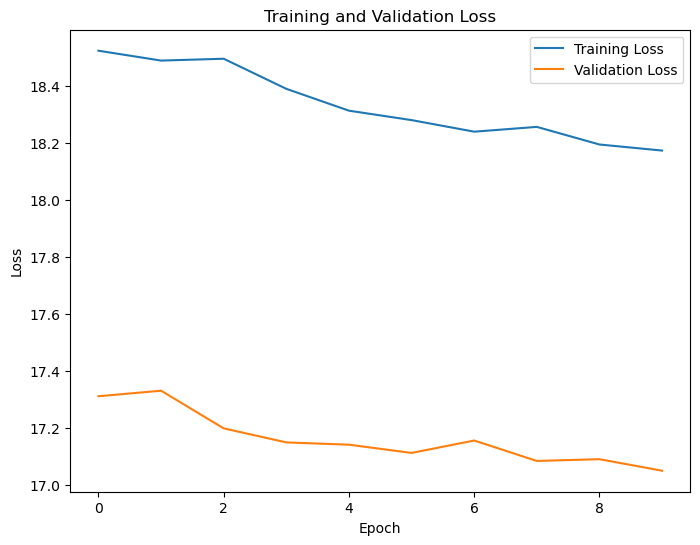

In [ ]:
# Plot training and validation losses
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.savefig("loss_plot.png")  # Save the plot
plt.show()

In [ ]:
y_pred= out

In [ ]:
y_test = np.array(features_csv[features_csv["split"]=="train"]["label"].values)

In [ ]:
np.unique(features_csv['gender'])

array(['female', 'male', 'unknown'], dtype=object)

In [ ]:
features_csv['col_encoded'] = features_csv['gender'].map({'female': 0, 'male': 1, 'unknown':1})

In [ ]:
np.unique(features_csv['col_encoded'])

array([0, 1])

In [ ]:
from fairlearn.metrics import demographic_parity_difference

# Assuming `gender` corresponds to the original metadata
# Split the dataset into training and testing sets for `gender`
gender_train, gender_test = features_csv[features_csv["split"]=="train"]["col_encoded"], features_csv[features_csv["split"]=="dev"]["col_encoded"]

# Ensure that `gender_test`, `y_test`, and `y_pred` are aligned
print(f"Shape of gender_test: {gender_train.shape}")
print(f"Shape of y_test: {y_test.shape}")
print(f"Shape of y_pred: {y_pred.shape}")



Shape of gender_test: (163,)
Shape of y_test: (163,)
Shape of y_pred: (163,)


In [ ]:
# Calculate Demographic Parity Difference
demographic_parity = demographic_parity_difference(
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=gender_train
)

print(f"Demographic Parity Difference: {demographic_parity}")

Demographic Parity Difference: 0.0


In [ ]:
from fairlearn.metrics import MetricFrame, selection_rate
metric_frame = MetricFrame(metrics=selection_rate, 
                           y_true=y_test, 
                           y_pred=y_pred, 
                           sensitive_features=gender_train)

# Get selection rates for each group
selection_rates = metric_frame.by_group
print("Selection Rates by Group:")
print(selection_rates)


Selection Rates by Group:
col_encoded
0    0.0
1    0.0
Name: selection_rate, dtype: float64


In [ ]:
group_a_rate = selection_rates[1]
group_b_rate = selection_rates[0]

if group_b_rate > 0:  # Avoid division by zero
    demographic_parity_ratio = group_a_rate / group_b_rate
    print(f"Demographic Parity Ratio: {demographic_parity_ratio}")

# balanced subset

In [20]:
# Filter rows that belong to the "train" split
features_csv = pd.read_csv("/home/hice1/mbibars3/scratch/vlm-debiasing/data/e-daic/norm_avt.csv")
train_df = features_csv[features_csv['split'] == 'train']
# Select a balanced subset based on 'label.1'
min_class_size = train_df['label.1'].value_counts().min()

# Sample an equal number of rows from each class
balanced_df = train_df.groupby('label.1').sample(n=min_class_size, random_state=42).reset_index(drop=True)


In [21]:
balanced_df=balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [22]:
train_loader = loaders.MultiModalityDataset(balanced_df[balanced_df["split"]=="train"], 
                                            modalities = {"audio", "text"}, label = "label.1")
train_dataloader = DataLoader(train_loader, batch_size=64, collate_fn=loaders.collate_fn)

for batch in train_dataloader:
    modalities, labels = batch
    print(f"Modality 1 shape: {modalities[0].shape}")  # Expected shape: (batch_size, feature, 1)
    print(f"Modality 2 shape: {modalities[1].shape}")
    #print(f"Modality 3 shape: {modalities[2].shape}")
    print(f"Labels shape: {labels}")
    break

Modality 1 shape: torch.Size([64, 768, 1])
Modality 2 shape: torch.Size([64, 768, 1])
Labels shape: tensor([1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
        1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
        1., 0., 1., 0., 1., 1., 1., 1., 0., 1.])


In [23]:
dev_loader = loaders.MultiModalityDataset(features_csv[features_csv["split"]=="dev"], 
                                            modalities = {"audio", "text"}, label = "label.1")
dev_dataloader = DataLoader(train_loader, batch_size=16, collate_fn=loaders.collate_fn)

In [24]:
# Define input dimensions for each modality
input_dims = [768, 768]  # These are the feature dimensions for each modality

# Initialize MultiModalPerceiver model
model = m.MultiModalPerceiver(
    input_dims=input_dims,
    input_channels=1,
    input_axis=1,
    projection_dim=256,
    num_latents=16,
    latent_dim=128,
    depth=8,
    cross_heads=8,
    latent_heads=8,
    cross_dim_head=32,
    latent_dim_head=32,
    attn_dropout=0.5,
    ff_dropout=0.5,
    output_dim=1,
    weight_tie_layers=True,
    fourier_encode_data=False,
    max_freq=10,
    num_freq_bands=4
)

In [25]:
simple_model = m.SimpleMultiModalityModel(input_dims, hidden_size=128, output_size=1)

# Print model summary
print(simple_model)

SimpleMultiModalityModel(
  (modality_fc): ModuleList(
    (0-1): 2 x Sequential(
      (0): Linear(in_features=768, out_features=128, bias=True)
      (1): ReLU()
    )
  )
  (combined_fc): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
)


In [26]:
sum(p.numel() for p in simple_model.parameters() if p.requires_grad)

229889

In [27]:
labels_torch = torch.from_numpy(balanced_df[balanced_df["split"]=="train"]["label.1"].values)

In [28]:
# Calculate class weights
class_counts = torch.bincount(labels_torch)  # Get counts for each class
class_weights = len(labels_torch) / (2.0 * class_counts)

# Apply weights to loss function
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])  # Weight for positive class


In [29]:
class_weights

tensor([1., 1.])

In [30]:
learning_rate = 0.001
num_epochs = 10
# Define loss function and optimizer
#criterion = nn.MSELoss()  # Mean Squared Error for regression
# loss function for binary classification
#criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(simple_model.parameters(), lr=learning_rate)

In [31]:
from sklearn.metrics import f1_score
# Define variables to track losses
train_losses = []
val_losses = []
best_val_loss = float('inf')  # Initialize best validation loss

# Training loop
for epoch in range(num_epochs):
    running_train_loss = 0.0
    all_train_labels = []
    all_train_preds = []
    all_dev_labels = []
    all_dev_preds = []

    for batch in train_dataloader:
        
        # Unpack the batch
        modalities, labels = batch
        modality_1, modality_2 = modalities  # Each has shape (batch_size, feature, 1)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        inputs = [modality_1, modality_2]
        output = simple_model(inputs)

        #print(output, labels)
        # Reshape labels to match the output shape if necessary
        labels = labels.view(output.shape)  # Ensures labels has shape (batch_size, 1)

        # Compute loss
        loss = criterion(output, labels)
        #RMSE_loss = torch.sqrt(loss)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Accumulate loss
        running_train_loss += loss.item()
        # Convert logits to predictions
        preds = torch.sigmoid(output) > 0.5
        all_train_labels.extend(labels.cpu().numpy().flatten())
        all_train_preds.extend(preds.cpu().numpy().flatten())

    # Average training loss for the epoch
    train_loss = running_train_loss / len(train_dataloader)
    train_losses.append(train_loss)

    # Validation Phase
    model.eval()  # Set model to evaluation mode
    running_val_loss = 0.0

    with torch.no_grad():  # Disable gradient computation
        for batch in dev_dataloader:  # Use validation DataLoader
            modalities, labels = batch
            modality_1, modality_2 = modalities

            # Forward pass
            inputs = [modality_1, modality_2]
            output = simple_model(inputs)

            # Reshape labels to match the output shape if necessary
            labels = labels.view(output.shape)

            # Compute loss
            loss = criterion(output, labels)
            #RMSE_loss = torch.sqrt(loss)

            running_val_loss += loss.item()
            preds = torch.sigmoid(output) > 0.5
            all_dev_labels.extend(labels.cpu().numpy().flatten())
            all_dev_preds.extend(preds.cpu().numpy().flatten())

    # Average validation loss for the epoch
    val_loss = running_val_loss / len(dev_dataloader)
    val_losses.append(val_loss)

    # Check if this is the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_aud_text_model.pth")  # Save best model

    # Compute F1-score for training
    train_f1 = f1_score(all_train_labels, all_train_preds, average='weighted')
    dev_f1 = f1_score(all_dev_labels, all_dev_preds, average='weighted')

    # Print epoch summary
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train F1: {train_f1:.4f}, Val F1: {dev_f1:.4f}")


Epoch [1/10], Train Loss: 0.7176, Val Loss: 0.6975, Train F1: 0.3835, Val F1: 0.3333
Epoch [2/10], Train Loss: 0.6922, Val Loss: 0.6877, Train F1: 0.3333, Val F1: 0.3333
Epoch [3/10], Train Loss: 0.6895, Val Loss: 0.6857, Train F1: 0.3333, Val F1: 0.3333
Epoch [4/10], Train Loss: 0.6913, Val Loss: 0.6854, Train F1: 0.3333, Val F1: 0.3333
Epoch [5/10], Train Loss: 0.6923, Val Loss: 0.6854, Train F1: 0.3333, Val F1: 0.3333
Epoch [6/10], Train Loss: 0.6926, Val Loss: 0.6856, Train F1: 0.3333, Val F1: 0.3333
Epoch [7/10], Train Loss: 0.6924, Val Loss: 0.6859, Train F1: 0.3333, Val F1: 0.3333
Epoch [8/10], Train Loss: 0.6921, Val Loss: 0.6863, Train F1: 0.3333, Val F1: 0.3333
Epoch [9/10], Train Loss: 0.6918, Val Loss: 0.6868, Train F1: 0.3333, Val F1: 0.3333
Epoch [10/10], Train Loss: 0.6916, Val Loss: 0.6871, Train F1: 0.3333, Val F1: 0.3333


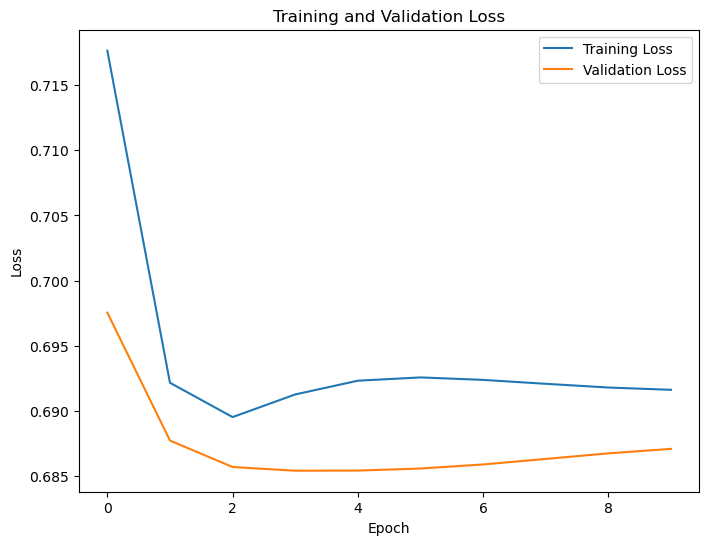

In [32]:
# Plot training and validation losses
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.savefig("loss_plot.png")  # Save the plot
plt.show()

In [33]:
# Model prediction
simple_model.eval()  # Set model to evaluation mode

predictions = []
with torch.no_grad():  # Disable gradient computation
    for batch in dev_dataloader:
        modalities, _ = batch  # Ignore labels if unavailable
        modality_1, modality_2 = modalities
        
        # Forward pass
        inputs = [modality_1, modality_2]
        output = simple_model(inputs)  # Model's prediction
        predictions = torch.sigmoid(output)  # Apply sigmoid activation
        predicted_classes = (predictions > 0.5).int()  # Convert probabilities to binary predictions
        #print(f"Predicted Probabilities:\n{predictions}")
        print(f"Predicted Classes:\n{predicted_classes}")
        # Collect predictions
        #predictions.append(output)

# Combine predictions into a single tensor
#predictions = torch.cat(predicted_classes, dim=0)
#y_pred = np.array(predictions)
#print(f"Predictions:\n{predictions}")

Predicted Classes:
tensor([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=torch.int32)
Predicted Classes:
tensor([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=torch.int32)
Predicted Classes:
tensor([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=torch.int32)
Predicted Classes:
tensor([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=torch.int32)
Predicted Cl

In [ ]:
y_test = np.array(features_csv[features_csv["split"]=="dev"]["PTSD_severity"].values)

In [ ]:
features_csv['col_encoded'] = features_csv['gender'].map({'female': 0, 'male': 1, None:1})

In [ ]:
np.unique(features_csv['col_encoded'])

array([ 0.,  1., nan])

In [ ]:
from fairlearn.metrics import demographic_parity_difference

# Assuming `gender` corresponds to the original metadata
# Split the dataset into training and testing sets for `gender`
gender_train, gender_test = features_csv[features_csv["split"]=="train"]["col_encoded"], features_csv[features_csv["split"]=="dev"]["col_encoded"]

# Ensure that `gender_test`, `y_test`, and `y_pred` are aligned
print(f"Shape of gender_test: {gender_test.shape}")
print(f"Shape of y_test: {y_test.shape}")
print(f"Shape of y_pred: {y_pred.shape}")



Shape of gender_test: (56,)
Shape of y_test: (56,)
Shape of y_pred: (56, 1)


In [ ]:
# Calculate Demographic Parity Difference
demographic_parity = demographic_parity_difference(
    y_true=y_test,
    y_pred=y_pred[:,0],
    sensitive_features=gender_test
)

print(f"Demographic Parity Difference: {demographic_parity}")

Demographic Parity Difference: 0.0


In [ ]:
from fairlearn.metrics import MetricFrame, selection_rate
metric_frame = MetricFrame(metrics=selection_rate, 
                           y_true=y_test, 
                           y_pred=y_pred[:,0], 
                           sensitive_features=gender_test)

# Get selection rates for each group
selection_rates = metric_frame.by_group
print("Selection Rates by Group:")
print(selection_rates)


Selection Rates by Group:
gender
female     0.0
male       0.0
unknown    0.0
Name: selection_rate, dtype: float64


In [ ]:
group_a_rate = selection_rates[1]
group_b_rate = selection_rates[0]

if group_b_rate > 0:  # Avoid division by zero
    demographic_parity_ratio = group_a_rate / group_b_rate
    print(f"Demographic Parity Ratio: {demographic_parity_ratio}")

/scratch/954025/ipykernel_2837344/1510568790.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  group_a_rate = selection_rates[1]
/scratch/954025/ipykernel_2837344/1510568790.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  group_b_rate = selection_rates[0]
